In [6]:
# Imports
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sb
import pandas as pd
import numpy as np

In [2]:
# check that gpu is available:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
# Load MNIST Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [17]:
# examine dataset
print(x_train.min(), x_train.max(), x_train.dtype, x_train.shape)
print(y_train.min(), y_train.max(), y_train.dtype, y_train.shape)

0 255 uint8 (60000, 28, 28)
0 9 uint8 (60000,)


In [18]:
# normalize images
x_train = x_train / 255.
x_test = x_test / 255.
x_train.shape += (1,)
x_test.shape += (1,)

In [ ]:
# use only small part of the dataset (~50 images pro class)
# it's actually 500 images in total
_, x_train, _, y_train = train_test_split(x_train, y_train, test_size=50*10, shuffle=True, random_state=42)

In [20]:
# examine normalized dataset
print(x_train.min(), x_train.max(), x_train.dtype, x_train.shape)
print(y_train.min(), y_train.max(), y_train.dtype, y_train.shape)

0.0 1.0 float64 (500, 28, 28, 1)
0 9 uint8 (500,)


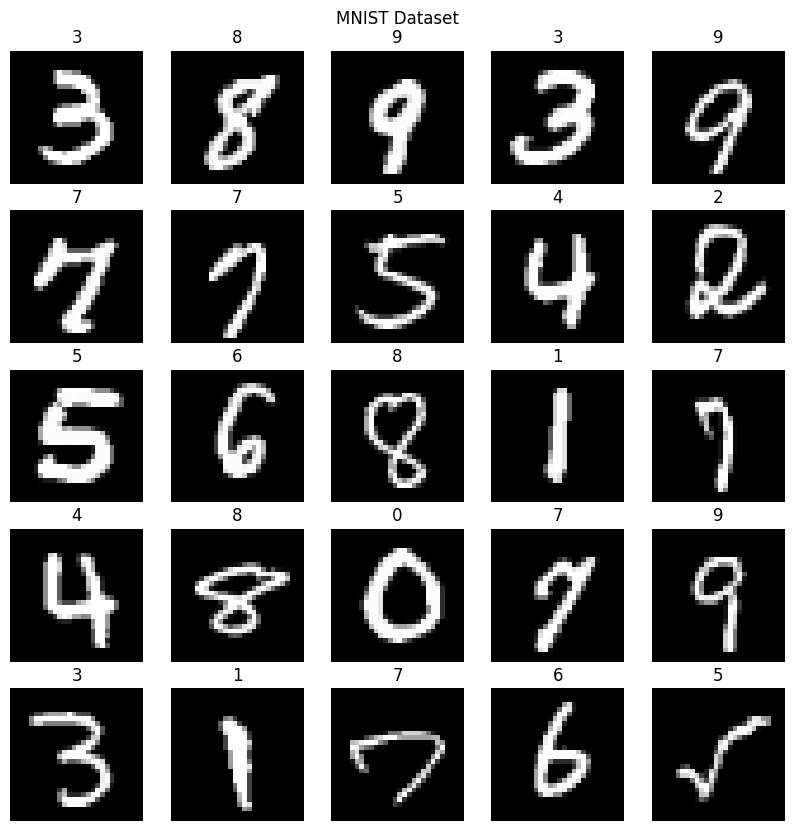

In [21]:
# Visualize some numbers
plt.figure(figsize=(10, 10))
plt.title("MNIST Dataset", pad=20)
plt.axis(False)

for i in range(0, 5):
    for j in range(0, 5):

        idx = i * 5 + j + 1
        plt.subplot(5, 5, idx)
        plt.imshow(x_train[idx], cmap="gray")
        plt.title(y_train[idx])
        plt.axis(False)

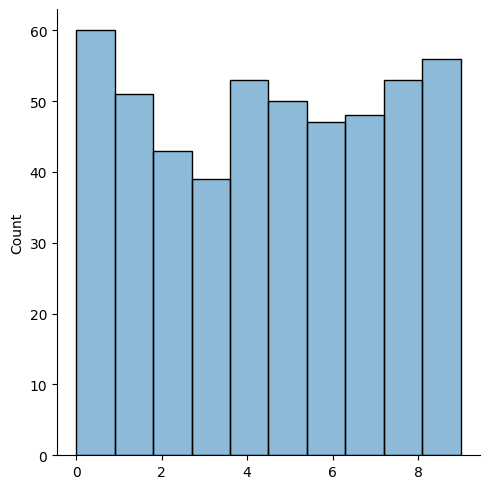

In [23]:
# inspect class distributions
df = pd.DataFrame(y_train)
sb.displot(df, legend=False)
del df

In [45]:
# some basic GAN

## discriminator
disc = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, 5, strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, 5, strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, 5, strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

## Generator
gen = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,)),
    tf.keras.layers.Dense(7*7*256, use_bias=False),
    tf.keras.layers.Reshape((7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(128, 5, strides=1, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(256, 5, strides=2, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(1, 5, strides=2, padding="same", activation="sigmoid", use_bias=False),
])

gen.output_shape

(None, 28, 28, 1)

0.47974885 0.5198663 float32 (16, 28, 28, 1)


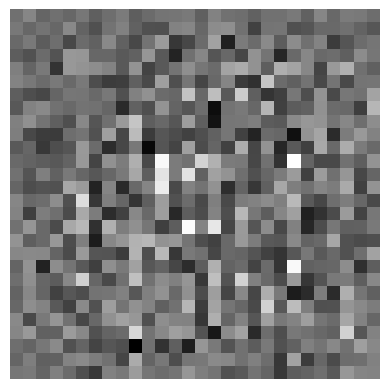

In [46]:
rand = tf.random.normal((16, 128, 1))
out = gen(rand, training=False)

plt.imshow(out[0], cmap="gray")
plt.axis(False)

out = out.numpy()
print(out.min(), out.max(), out.dtype, out.shape)
del out, rand

In [47]:
## losses
bc = tf.keras.losses.BinaryCrossentropy()
def discriminator_loss(real, fake):
    real_loss = bc(tf.ones_like(real), real)
    fake_loss = bc(tf.zeros_like(fake), fake)
    return real_loss + fake_loss

def generator_loss(fake):
    return bc(tf.ones_like(fake), fake)

In [48]:
## combined model
class GAN(tf.keras.Model):
    def __init__(self, gen, disc):
        super().__init__()

        self.gen = gen
        self.disc = disc

    def compile(self, g_optimizer, d_optimizer, gen_loss, disc_loss):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss

    def train_step(self, real_images):
        shape = tf.shape(real_images)
        rand = tf.random.normal((shape[0], 128, 1))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            fake_images = self.gen(rand, training=True)

            out = self.disc(real_images, training=True)
            fake_out = self.disc(fake_images, training=True)

            g_loss = self.gen_loss(fake_out)
            d_loss = self.disc_loss(out, fake_out)

        gen_grads = gen_tape.gradient(g_loss, self.gen.trainable_weights)
        disc_grads = disc_tape.gradient(d_loss, self.disc.trainable_weights)
        self.d_optimizer.apply_gradients(zip(disc_grads, self.disc.trainable_weights))
        self.g_optimizer.apply_gradients(zip(gen_grads, self.gen.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [49]:
gan = GAN(gen, disc)

gan.compile(
    tf.keras.optimizers.Adam(1e-4),
    tf.keras.optimizers.Adam(1e-4),
    generator_loss,
    discriminator_loss
)

In [50]:
# define callbacks
def draw_random():
    # Visualize results
    rand = tf.random.normal((25, 128, 1))
    out = gen(rand, training=False)

    fig = plt.figure(figsize=(10, 10))
    canvas = fig.canvas
    for i in range(5):
        for j in range(5):
            idx = i * 5 + j
            plt.subplot(5, 5, idx + 1)
            plt.axis(False)
            plt.imshow(out[idx], cmap="gray")

    plt.tight_layout()
    canvas.draw()
    return canvas

def visualize(epoch, filew):
    canvas = draw_random()
    image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image_flat.reshape(*reversed(canvas.get_width_height()), 3)
    plt.close()
    with filew.as_default():
        tf.summary.image("Generation Results", image.reshape((1,) + image.shape), epoch)

logdir = "mnist-gan/logs/"
file_writer = tf.summary.create_file_writer(logdir + "images/")
write_images_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: visualize(epoch, file_writer))

callbacks = [
    tf.keras.callbacks.CSVLogger("mnist-gan/mnist-gan.csv"),
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.TensorBoard(logdir),
    write_images_callback,
]

In [51]:
history = gan.fit(x_train, batch_size=32, epochs=200, callbacks=callbacks)

Epoch 1/200


16/16 [==============================] - 3s 50ms/step - d_loss: 0.6024 - g_loss: 2.7414
Epoch 2/200
 3/16 [====>.........................] - ETA: 0s - d_loss: 0.0703 - g_loss: 4.2400

C:\Users\danya\AppData\Local\Temp\ipykernel_24904\2707781873.py:22: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


16/16 [==============================] - 1s 69ms/step - d_loss: 0.0804 - g_loss: 4.1427
Epoch 3/200
16/16 [==============================] - 1s 61ms/step - d_loss: 0.1069 - g_loss: 3.8204
Epoch 4/200
16/16 [==============================] - 1s 56ms/step - d_loss: 0.0569 - g_loss: 4.7436
Epoch 5/200
16/16 [==============================] - 1s 54ms/step - d_loss: 0.1072 - g_loss: 4.4670
Epoch 6/200
16/16 [==============================] - 1s 52ms/step - d_loss: 0.0912 - g_loss: 4.5923
Epoch 7/200
16/16 [==============================] - 1s 72ms/step - d_loss: 0.0849 - g_loss: 4.7218
Epoch 8/200
16/16 [==============================] - 1s 56ms/step - d_loss: 0.1448 - g_loss: 4.4226
Epoch 9/200
16/16 [==============================] - 1s 60ms/step - d_loss: 0.0970 - g_loss: 5.1300
Epoch 10/200
16/16 [==============================] - 1s 53ms/step - d_loss: 0.1069 - g_loss: 4.7524
Epoch 11/200
16/16 [==============================] - 1s 61ms/step - d_loss: 0.1226 - g_loss: 4.8224
Epoch 12/2

C:\Users\danya\AppData\Local\Temp\ipykernel_24904\4186012342.py:14: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


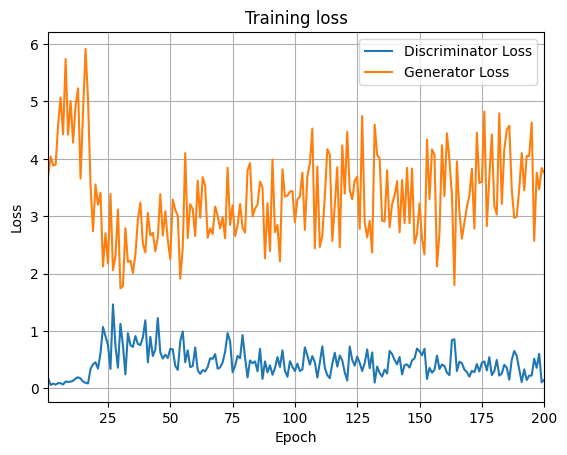

In [53]:
## Visualize training process
fig = plt.figure()
canvas = fig.canvas
plt.title("Training loss")
plt.plot(list(range(1, 201)), history.history["d_loss"])
plt.plot(list(range(1, 201)), history.history["g_loss"])
plt.xlim(1, 200)
plt.grid()
plt.legend(["Discriminator Loss", "Generator Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
canvas.draw()

image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
image = image_flat.reshape(*reversed(canvas.get_width_height()), 3)
with file_writer.as_default():
        tf.summary.image("Training losses", image.reshape((1,) + image.shape), 1)

to start tensorboard:
```
tensorboard --samples_per_plugin images=100 --logdir mnist-gan/logs
```

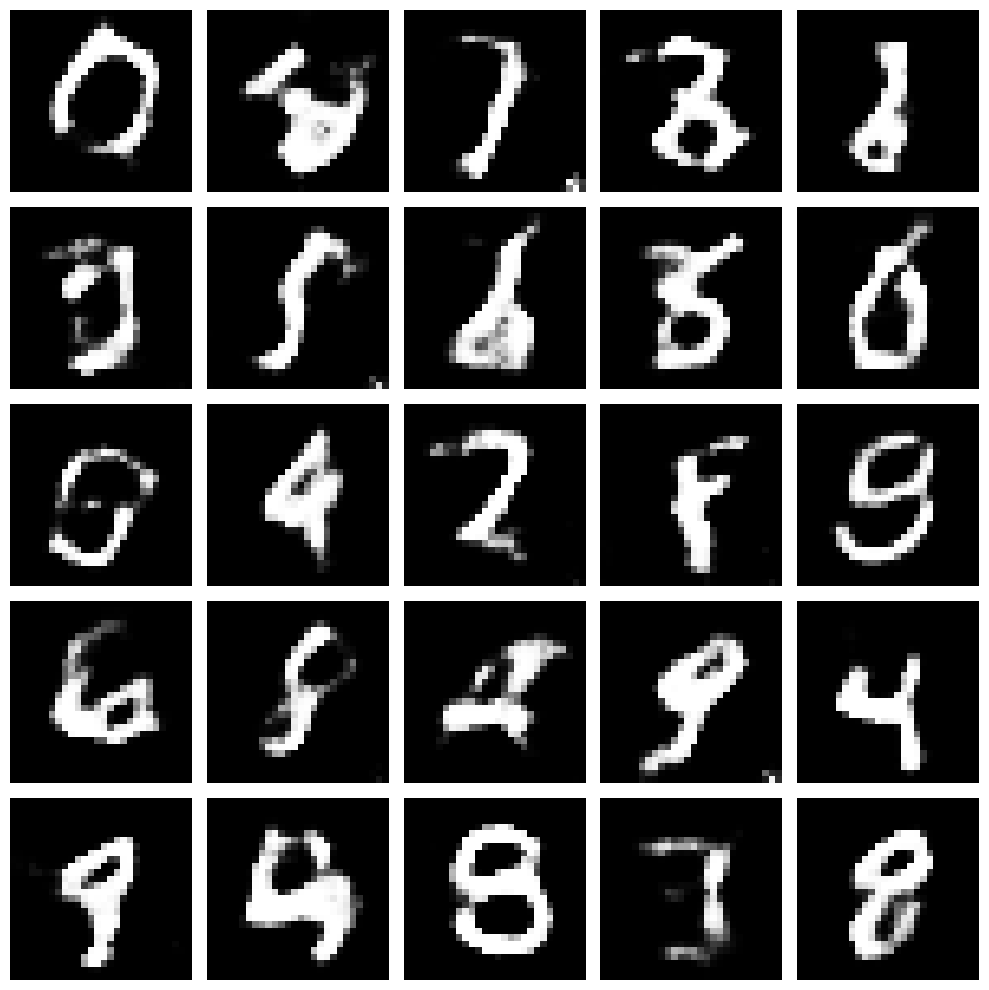

In [54]:
draw_random()

In [55]:
# save models
gen.save("mnist-gan/gen.keras")
disc.save("mnist-gan/disc.keras")